# Klasyfikacja raka mózgu - Hubert Jaremko

## Sieć konwolucyjna

In [18]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import walk
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

### Ustawienia

In [4]:
cancer_type = {0 : 'Oponiak', 1 : 'Glejak', 2 : 'Guz przysadki', 3 : 'Zdrowy'}

In [167]:
# image_size = (512, 512)
# image_size = (224, 224)
# image_size = (128, 128)
# image_size = (64, 64)
image_size = (56, 56)
batch_size = 32

train_dir = "data/train"
val_dir = "data/val"

## Funkcje pomocnicze

## Wczytanie zbioru testowego i walidacyjnego

*Augmentacja danych* - losowe odbijanie w poziomie i pionie oraz zmiana jasności obrazu.

In [168]:
train_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.5, 1.5)
#     brightness_range=(0.6, 1.3)
#     brightness_range=(0.7, 1.2)
#     brightness_range=(1.0, 2.0)
)

train_data_generator = train_generator.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

train_steps_per_epoch = np.math.ceil(train_data_generator.samples / train_data_generator.batch_size)


Found 3844 images belonging to 4 classes.


In [169]:
test_generator = ImageDataGenerator()

test_data_generator = test_generator.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

Found 963 images belonging to 4 classes.


### Próbka zbioru testowego

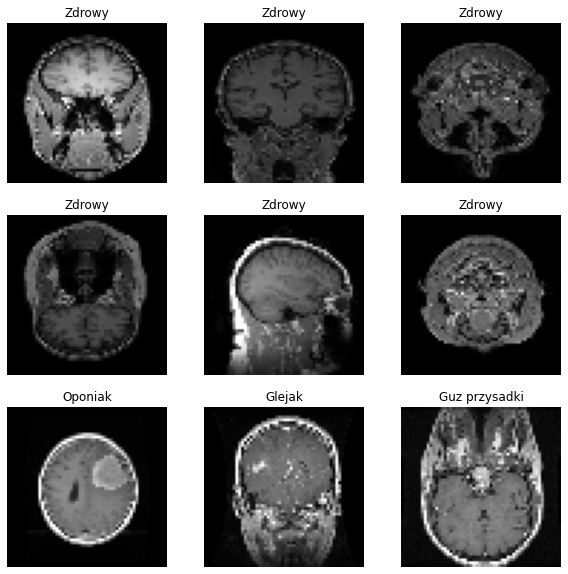

In [170]:
plt.figure(figsize=(10, 10))

b = next(train_data_generator)

images = b[0]
labels = b[1]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = images[i]
    label = labels[i]
    plt.imshow(image.astype("uint8"))
    plt.axis('off')
    label = cancer_type[np.argmax(label)]
    plt.title(label, fontsize=12)
plt.savefig('preprocessed.pdf', dpi=300)

<Figure size 432x288 with 0 Axes>

In [15]:
# train_ds = train_ds.prefetch(buffer_size=32)
# val_ds = val_ds.prefetch(buffer_size=32)

## Model
https://www.sciencedirect.com/science/article/pii/S2666827020300049

In [171]:
def make_lunet_model(input_shape):
#     activation = "relu"
    activation = "elu"
    model = tf.keras.models.Sequential()

    model.add(layers.InputLayer(input_shape))
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255))
# ---------
    model.add(Conv2D(32, (3, 3), padding='same', activation=activation))
    model.add(Conv2D(32, (3, 3), padding='same', activation=activation))
    
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Activation(activation))
# ---------
    model.add(Conv2D(64, (3, 3), padding='same', activation=activation))
    model.add(Conv2D(64, (3, 3), padding='same', activation=activation))
    
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Activation(activation))
# ---------
    model.add(tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2)))
    model.add(Activation(activation))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation=activation))
    model.add(Conv2D(64, (3, 3), padding='same', activation=activation))
# ---------
    model.add(tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2)))
    model.add(Activation(activation))
    
    model.add(Conv2D(32, (3, 3), padding='same', activation=activation))
    model.add(Conv2D(32, (3, 3), padding='same', activation=activation))
# ---------

    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dense(128, activation=activation))
    model.add(Dense(4, activation="softmax"))
    return model

In [108]:
np.math.floor((112 - 2) / 2) + 1

56

In [172]:
model = make_lunet_model(input_shape=image_size + (3,))
# model = make_vgg_model(input_shape=image_size + (3,))
keras.utils.plot_model(model, show_shapes=True)
history = History()
# model.build(image_size + (3,))
model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_58 (Rescaling)     (None, 56, 56, 3)         0         
_________________________________________________________________
conv2d_355 (Conv2D)          (None, 56, 56, 32)        896       
_________________________________________________________________
conv2d_356 (Conv2D)          (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 28, 28, 32)        0         
_________________________________________________________________
activation_194 (Activation)  (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_357 (Conv2D)          (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_358 (Conv2D)          (None, 28, 28, 64)      

In [165]:
model_path = 'models/no_oversampling_lunet_32_epoch.model'
history_path = model_path + '.history'

In [ ]:
# model = tf.keras.models.load_model(model_path)
# history = pickle.load(open(history_path), "rb")

In [173]:
epochs = 32

callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
#     EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1),
    history,
]

model.compile(
#     optimizer=keras.optimizers.Adam(0.00001),
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=[
        "categorical_accuracy",
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
    ],
)

history = model.fit(
    train_data_generator,
    steps_per_epoch=train_steps_per_epoch,

    validation_data=test_data_generator,
    validation_steps=test_steps_per_epoch,

    epochs=epochs,
    callbacks=callbacks, 
)

Epoch 1/32
121/121 [==============================] - 175s 1s/step - loss: 0.8494 - categorical_accuracy: 0.6808 - precision: 0.7447 - recall: 0.6002 - auc: 0.8856 - val_loss: 0.5389 - val_categorical_accuracy: 0.7653 - val_precision: 0.7905 - val_recall: 0.7404 - val_auc: 0.9499
Epoch 2/32
121/121 [==============================] - 181s 1s/step - loss: 0.5339 - categorical_accuracy: 0.7786 - precision: 0.8157 - recall: 0.7425 - auc: 0.9502 - val_loss: 0.4777 - val_categorical_accuracy: 0.7902 - val_precision: 0.8289 - val_recall: 0.7497 - val_auc: 0.9583
Epoch 3/32
121/121 [==============================] - 191s 2s/step - loss: 0.4375 - categorical_accuracy: 0.8197 - precision: 0.8420 - recall: 0.7929 - auc: 0.9658 - val_loss: 0.5605 - val_categorical_accuracy: 0.7965 - val_precision: 0.8085 - val_recall: 0.7715 - val_auc: 0.9525
Epoch 4/32
121/121 [==============================] - 175s 1s/step - loss: 0.3801 - categorical_accuracy: 0.8468 - precision: 0.8600 - recall: 0.8325 - auc: 

In [2]:
def plot_metrics(history):
    metrics = ['loss', 'categorical_accuracy', 'precision', 'recall']
    metrics_pl = ['Błąd', 'Dokładność', 'Precyzja', 'Czułość']
    
    plt.figure(figsize=(12, 7), constrained_layout = True)
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label='Zbiór treningowy')
        plt.plot(history.epoch, history.history['val_' + metric], linestyle="-", label='Zbiór walidacyjny')
        plt.xlabel('Epoka', fontsize=12)
        plt.ylabel(metrics_pl[n], fontsize=12)
        plt.ylim([0, 1])
        plt.legend()


In [3]:
plot_metrics(history)
# plt.subplot_tool()
plt.savefig('model_history.pdf', dpi=300)

NameError: name 'history' is not defined

In [185]:
import pickle

model.save(model_path)
with open(history_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: models/no_oversampling_lunet_32_epoch.model\assets


In [25]:
model.evaluate(test_data_generator)

25/25 [==============================] - 4s 155ms/step - loss: 0.4104 - categorical_accuracy: 0.9262 - precision: 0.9286 - recall: 0.9262 - auc: 0.9839


[0.4103669226169586,
 0.9262499809265137,
 0.9285714030265808,
 0.9262499809265137,
 0.9838778972625732]

In [175]:
predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

In [176]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

In [177]:
import sklearn.metrics
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           1       0.76      0.73      0.74       142
           2       0.87      0.90      0.88       286
           3       0.98      0.94      0.96       186
           4       0.98      1.00      0.99       349

    accuracy                           0.92       963
   macro avg       0.90      0.89      0.89       963
weighted avg       0.92      0.92      0.92       963



In [179]:
def plot_confusion_matrix(y_pred, y_true):
    plt.figure(figsize=(9, 7))
    cm = metrics.confusion_matrix(y_pred=predicted_classes, y_true=true_classes)
    sn.heatmap(cm, annot=True, fmt='g', cmap="RdPu", xticklabels=target, yticklabels=target)
    plt.xlabel('Klasy rzeczywiste', fontsize=20, labelpad=20)
    plt.ylabel('Predykcje', fontsize=20, labelpad=20)
#     plt.show()

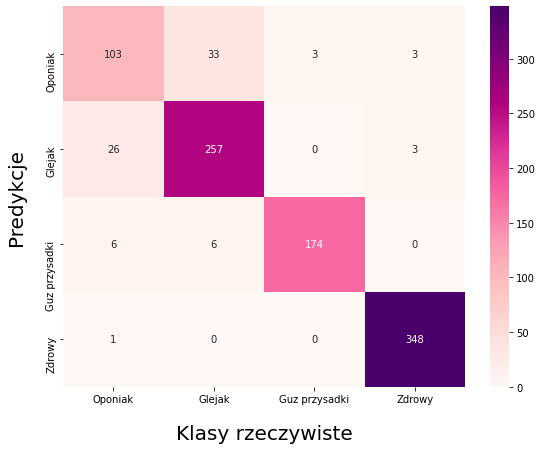

In [180]:
plot_confusion_matrix(predicted_classes, true_classes)
plt.savefig('model_confusion.pdf', dpi=300)

In [181]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target = ['Oponiak', 'Glejak', 'Guz przysadki', 'Zdrowy']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

def binarize_labels(y_test):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return y_test

def multiclass_roc_auc_score(y_test, y_pred, c_axs, average="macro"):
    y_test = binarize_labels(y_test)
    
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        
        i = idx // 2
        j = idx % 2
        c_axs[i, j].plot(fpr, tpr, label = f'{c_label} (AUC:{auc(fpr, tpr):0.2f})', color=colors[idx])
#         print(i + )
        c_axs[i, j].plot(fpr, fpr, '--', color = '0.75', label = 'Wybór losowy')
        c_axs[i, j].legend()
        c_axs[i, j].set_xlabel('Odsetek fałszywie pozytywnych', fontsize=12)
        c_axs[i, j].set_ylabel('Odsetek prawdziwie pozytywnych', fontsize=12)
    return roc_auc_score(y_test, y_pred, average=average)

def plot_roc_curve(y_test, y_pred):
    fig, c_axs = plt.subplots(2, 2, figsize = (13, 8))

    print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred, c_axs))


#     plt.show()

ROC AUC score: 0.9875675011358023


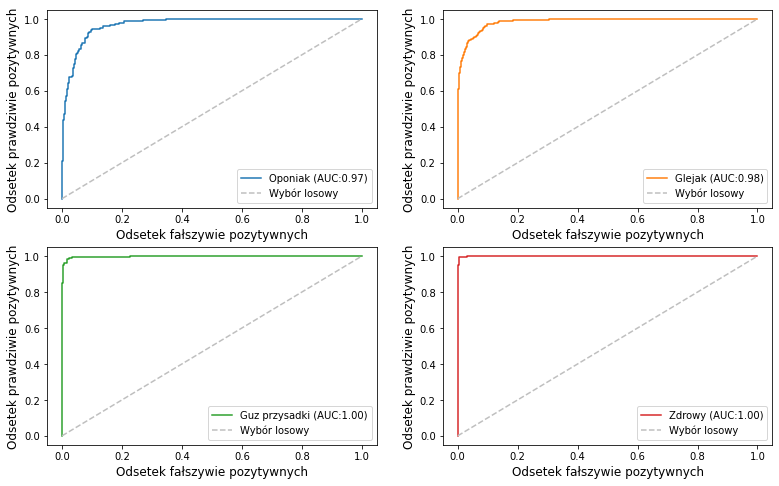

In [182]:
plot_roc_curve(true_classes, predictions)
plt.savefig('model_roc.pdf', dpi=300)

In [183]:
def print_proba(score, i):
    print(
    f"{cancer_type[i]} : {score[i] * 100:0.2f}%"
)

In [184]:
img = keras.preprocessing.image.load_img(
    "data/val/3/13.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# print(img_array.shape)

p = model.predict(img_array)
score = p[0]
# print(score)
print_proba(score, 0)
print_proba(score, 1)
print_proba(score, 2)
print_proba(score, 3)

Oponiak : 0.00%
Glejak : 0.00%
Guz przysadki : 100.00%
Zdrowy : 0.00%
